In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from imageio import imread
from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_closing, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label, regionprops
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.transform import warp, AffineTransform, rotate
from skimage.feature import canny

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

In [28]:
def rotate_pic(img):
    img_gray = rgb2gray(img)
    total_mask = get_total_mask(img_gray)
    audio_mask = binary_dilation(get_audio_mask(img_gray), selem=np.ones((10, 10)))
    box_mask = binary_opening(total_mask ^ audio_mask, selem=np.ones((20, 20)))
    x0, y0 = find_box_center(box_mask)
    h, theta, d = hough_line(canny(box_mask))
    average_angle = 0
    size = 0
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        if angle > angle_eps and angle < np.pi/2 - angle_eps:
            average_angle += angle
            size += 1
    if size == 0:
        return img
    average_angle /= size
    if average_angle > np.pi/4:
        average_angle = np.pi/2-average_angle
    if average_angle > angle_eps:
        img = rotate(img, -np.rad2deg(average_angle), center=(x0,y0), mode='edge')
        
    return img

In [14]:
def get_total_mask(img_gray):
    edge_map = binary_closing(canny(img_gray, sigma=1), selem=np.ones((9, 9)))
    areas = binary_fill_holes(edge_map)
    return areas

In [15]:
def get_audio_mask(img_gray):
    black_mask = img_gray < 0.25
    return binary_fill_holes(black_mask)

In [16]:
def find_box_center(mask):
    labels = label(mask)
    props = regionprops(labels)
    areas = [prop.area for prop in props]
    largest_comp_id = np.array(areas).argmax()
    y0, x0 = props[largest_comp_id].centroid
    return x0, y0

In [17]:
def find_largest_components(mask, img, obj_name, ax):
    # ищем максимальную компоненту
    labels = label(mask)
    props = regionprops(labels)
    areas = [prop.area for prop in props]
    largest_comp_id = np.array(areas).argmax()
    # вычисляем размеры "коробки" вокруг аудиогида
    minr, minc, maxr, maxc = props[largest_comp_id].bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    if obj_name == 'box':
        ax.plot(bx, by, '-b', linewidth=1)
    else:
        ax.plot(bx, by, '-r', linewidth=1)
    
    # ширина прямоугольника вокруг объекта
    box_width = maxr - minr     
    
    # высота прямоугольника вокруг объекта
    box_height = maxc - minc      
    
    # возвращаем характерные размеры предмета (коробка в которую он помещается)
    return box_width, box_height

In [18]:
def find_box(img, img_gray, ax):
    areas = get_total_mask(img_gray)
    return find_largest_components(areas, img, 'box', ax)

In [19]:
def find_audioguide(img, img_gray, ax):
    black_mask = get_audio_mask(img_gray)
    #audioguide_mask = binary_opening(black_mask, selem=np.ones((30, 30)))
    return find_largest_components(black_mask, img, 'audio', ax)

In [20]:
def eval_tests(img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # рисуем исходное изображение
    ax[0].imshow(img, cmap='gray')
    # поворачиваем изображение, чтобы коробка находилась параллельно осям
    img = rotate_pic(img)
    # рисуем повернутое изображение
    ax[1].imshow(img, cmap='gray')
    img_gray = rgb2gray(img)
    w_box, h_box = find_box(img, img_gray, ax[1])
    w_audio, h_audio = find_audioguide(img, img_gray, ax[1])
    test_res = w_box > w_audio and h_box > h_audio
    
    plt.show()
    print(f'Test result:{test_res}')
    return test_res

In [21]:
angle_eps = np.radians(5) # угол при котором мы еще не поворачиваем картинку

1.2548819817411743
1.2548819817411743
1.237331184793745
1.2724327786886032


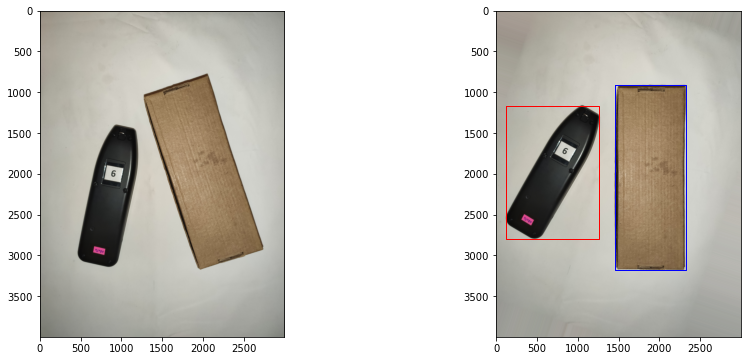

Test result:False
01.jpg
0.9740692305823102
0.9565184336348809
0.9740692305823102
0.9916200275297391
0.938967636687452
0.9916200275297391
1.009170824477168


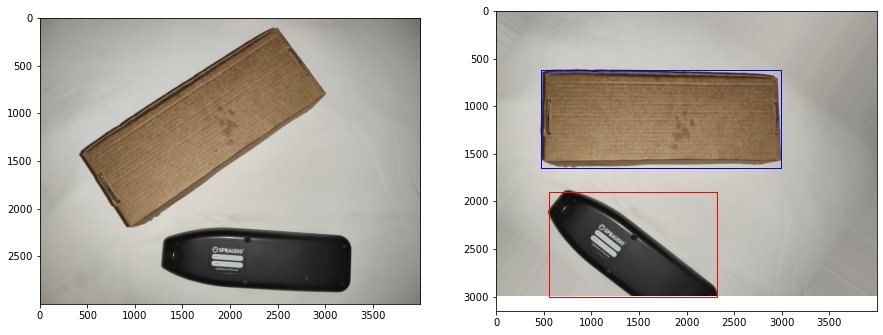

Test result:False
02.jpg


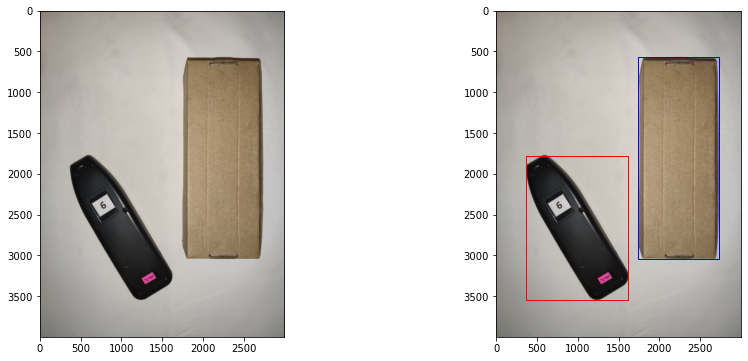

Test result:False
03.jpg


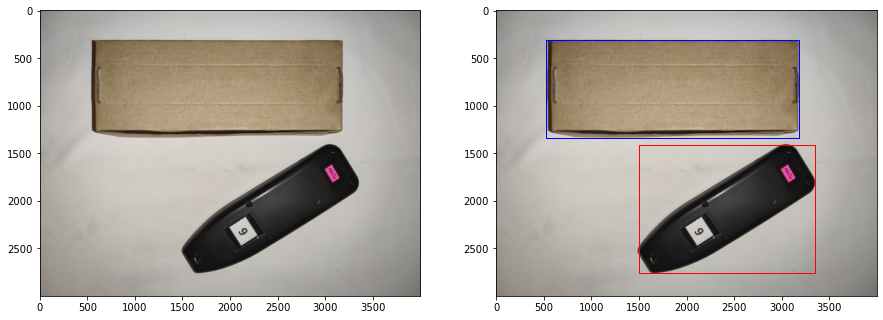

Test result:False
04.jpg


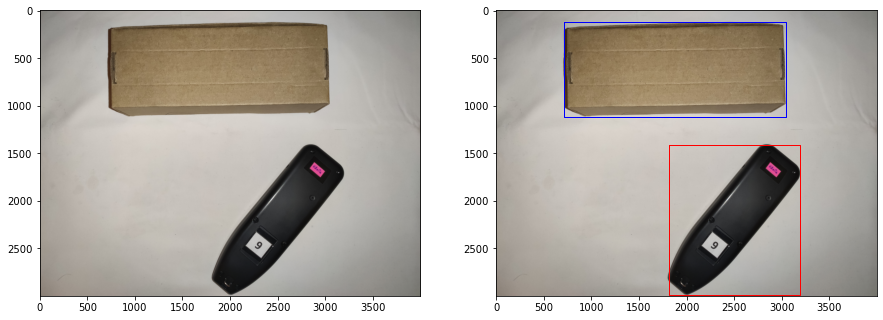

Test result:False
05.jpg


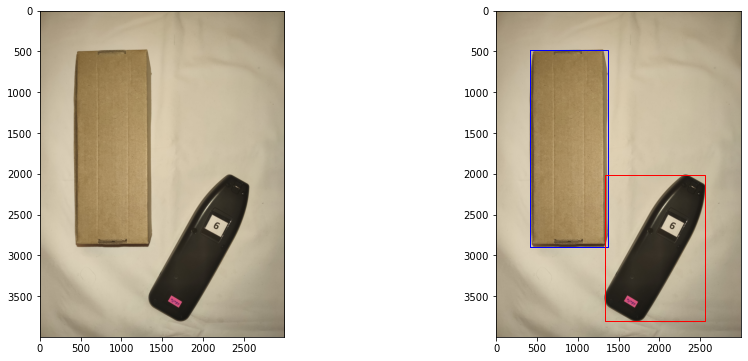

Test result:False
06.jpg


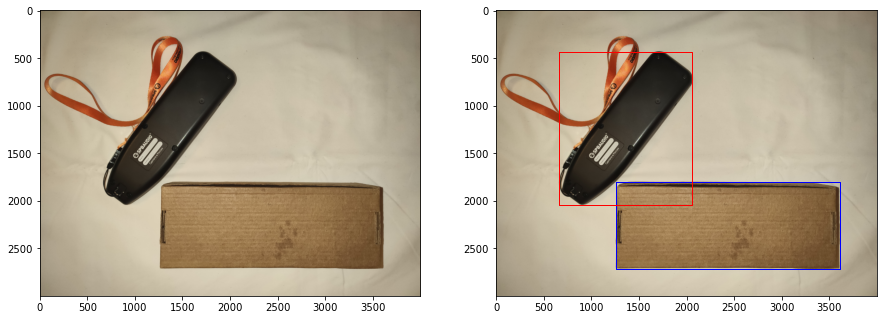

Test result:False
07.jpg


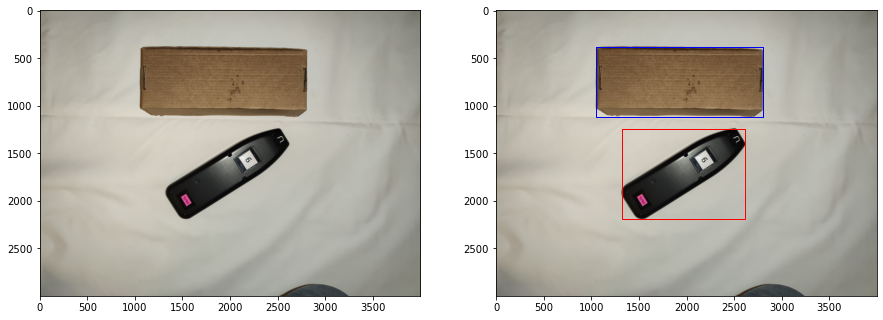

Test result:False
08.jpg


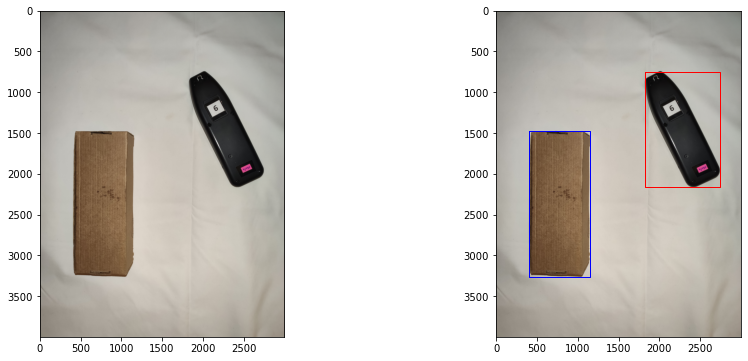

Test result:False
09.jpg


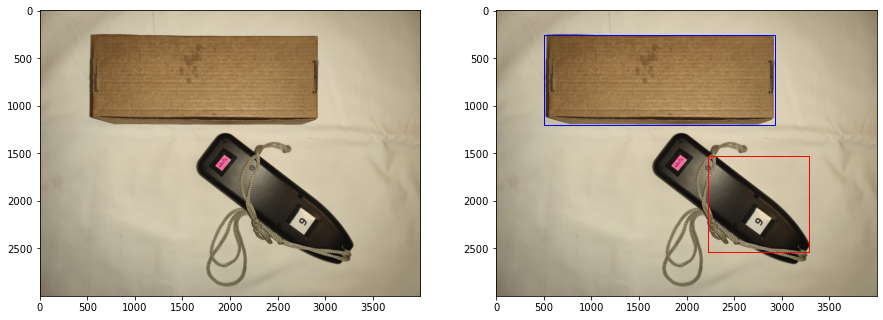

Test result:False
10.jpg


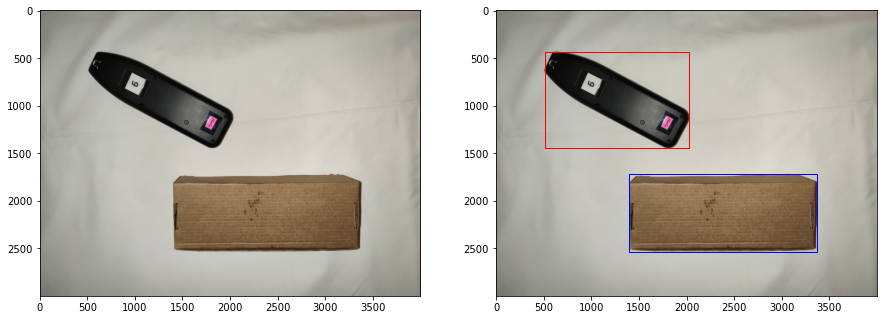

Test result:False
11.jpg
1.4830423420577512


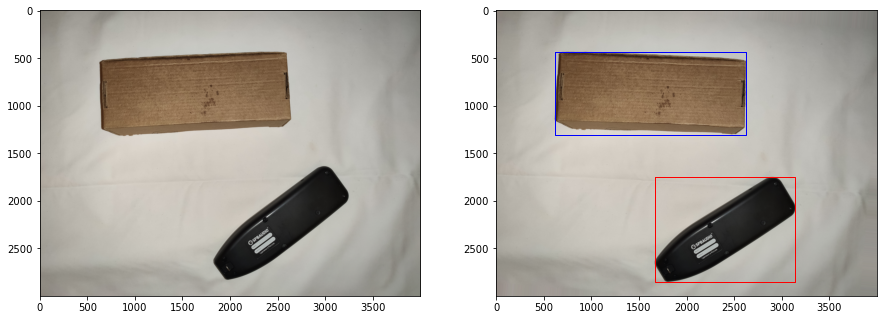

Test result:False
12.jpg


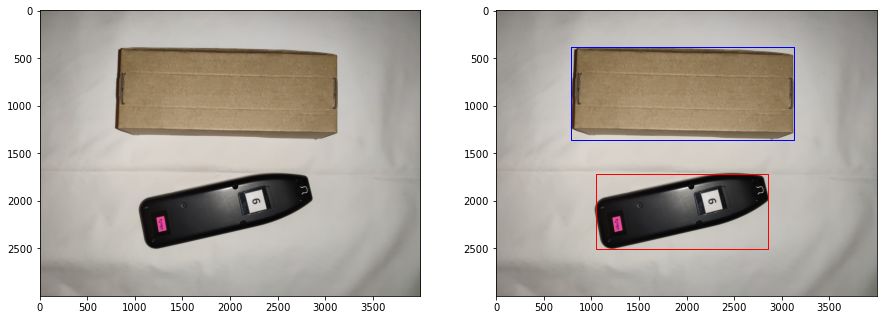

Test result:True
13.jpg


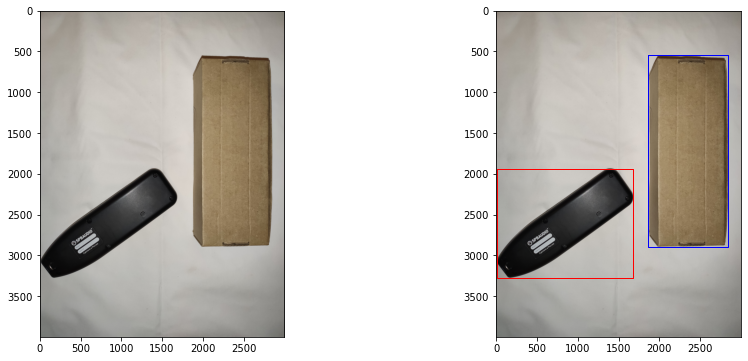

Test result:False
14.jpg


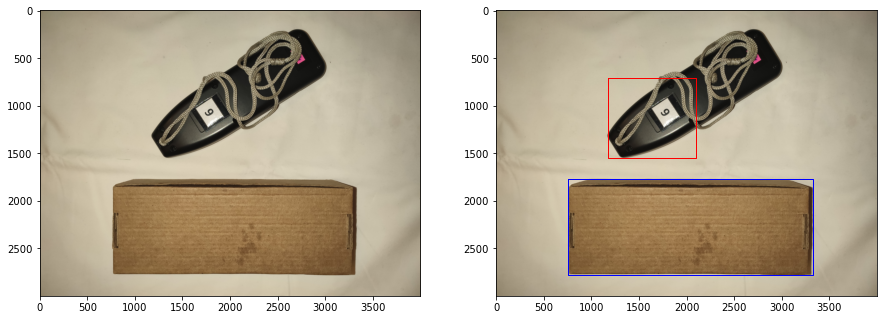

Test result:True
15.jpg


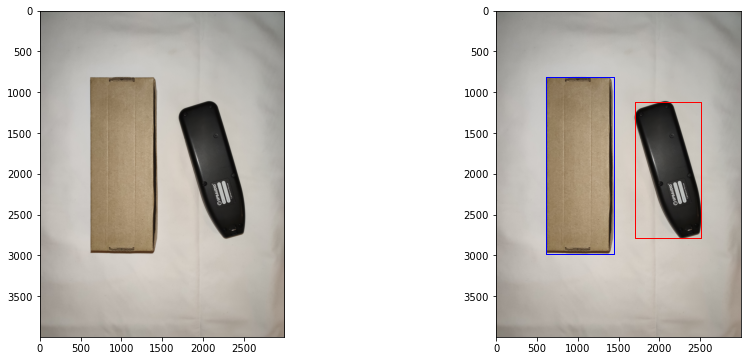

Test result:True
16.jpg


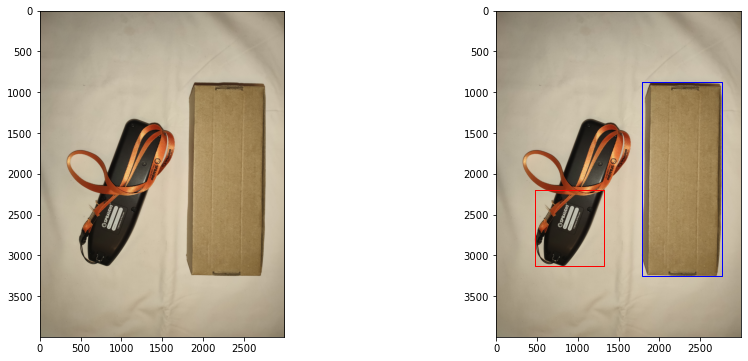

Test result:True
17.jpg


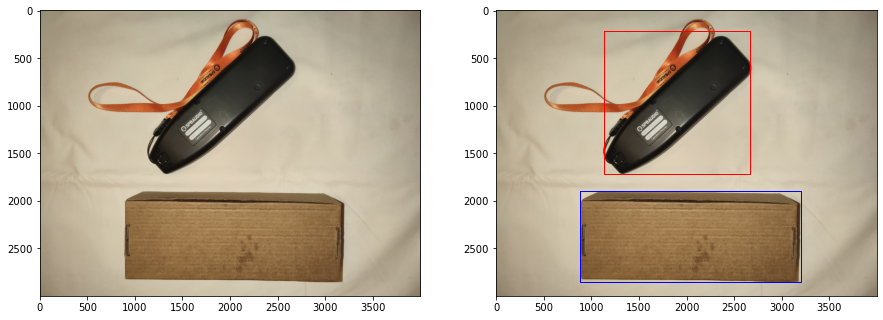

Test result:False
18.jpg


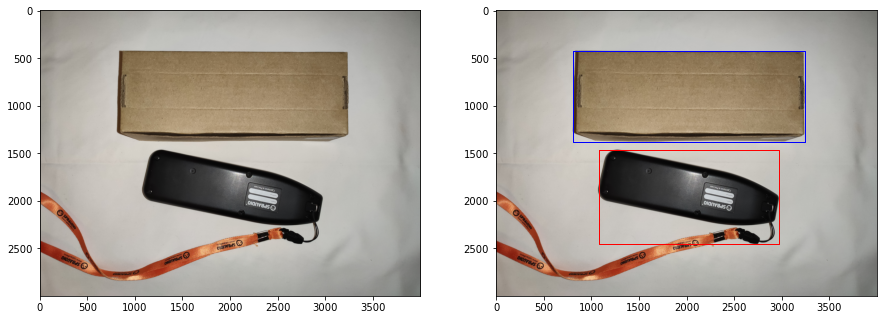

Test result:False
19.jpg


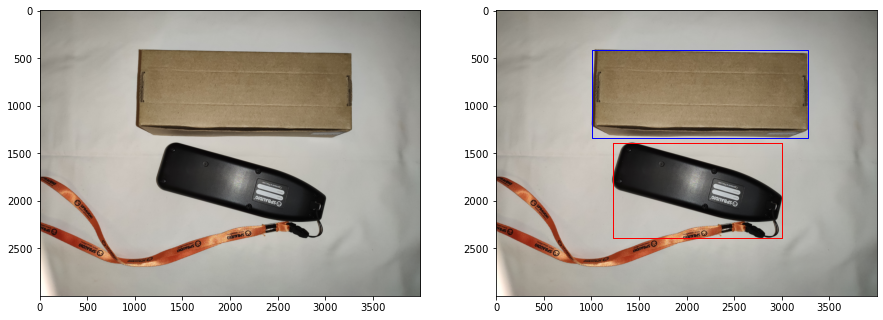

Test result:False
20.jpg


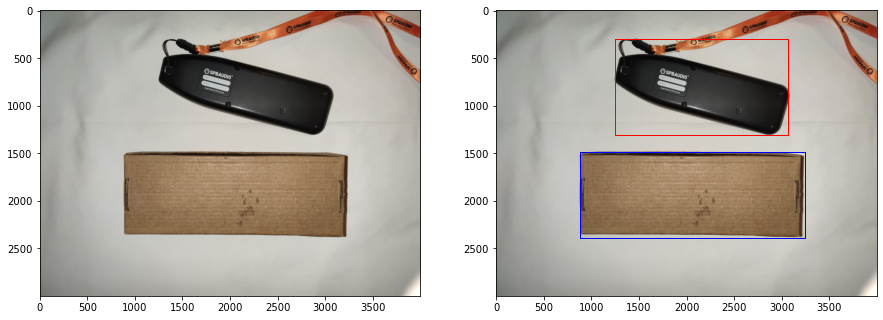

Test result:False
21.jpg


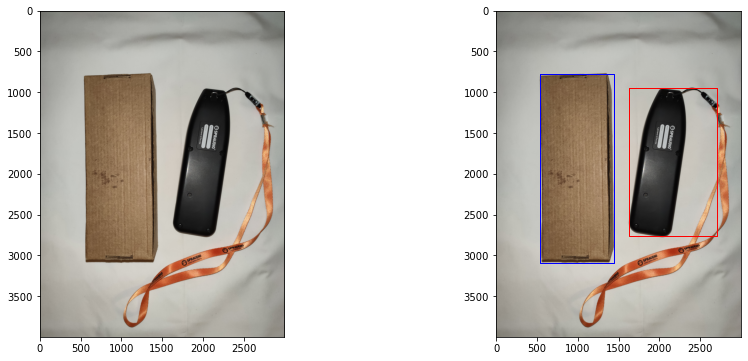

Test result:False
22.jpg


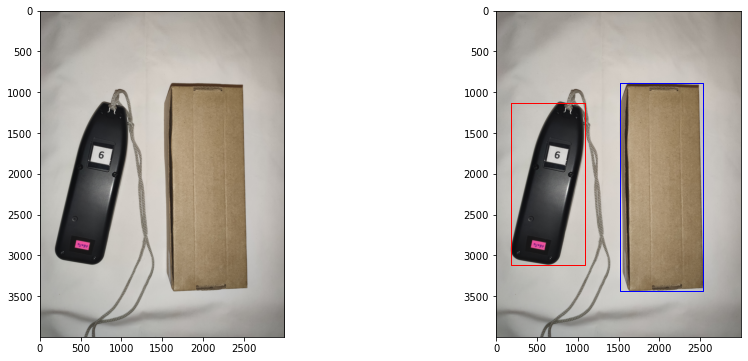

Test result:True
23.jpg


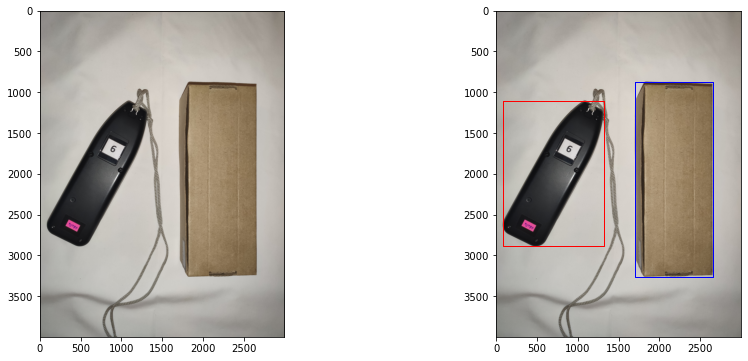

Test result:False
24.jpg


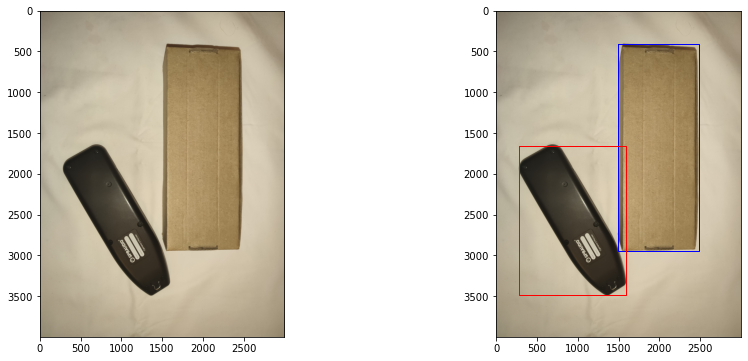

Test result:False
25.jpg


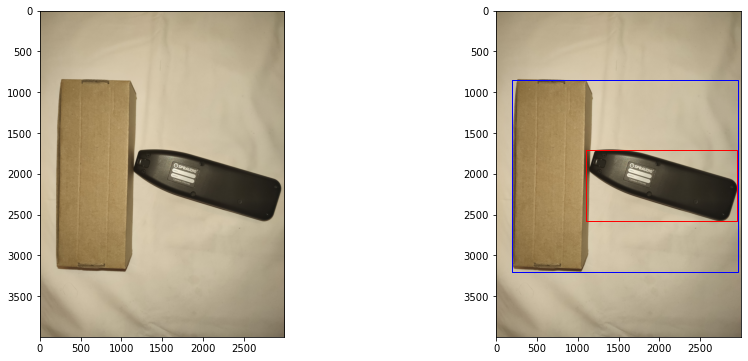

Test result:True
26.jpg
1.1144756061617422
1.1144756061617422


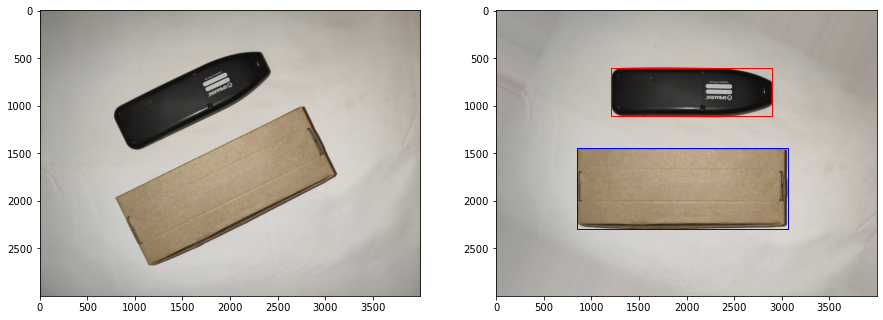

Test result:True
01.jpg


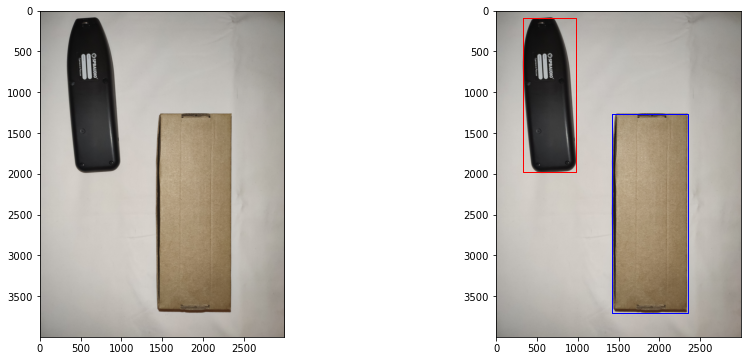

Test result:True
02.jpg


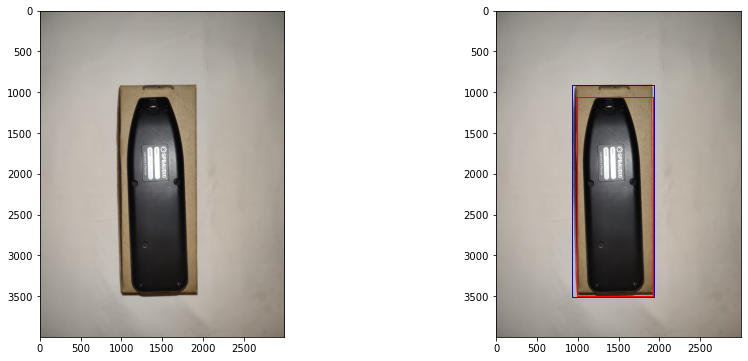

Test result:True
03.jpg


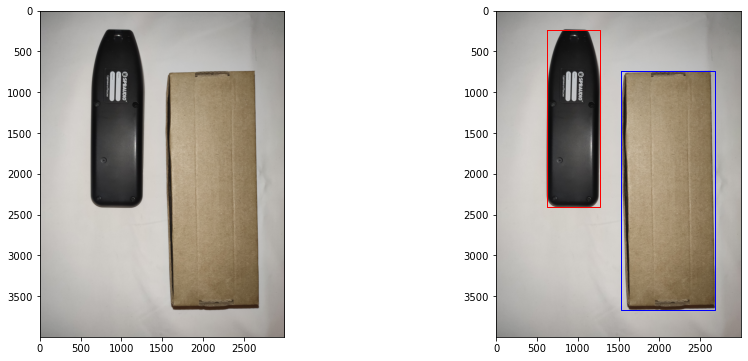

Test result:True
04.jpg
0.2369357587902916


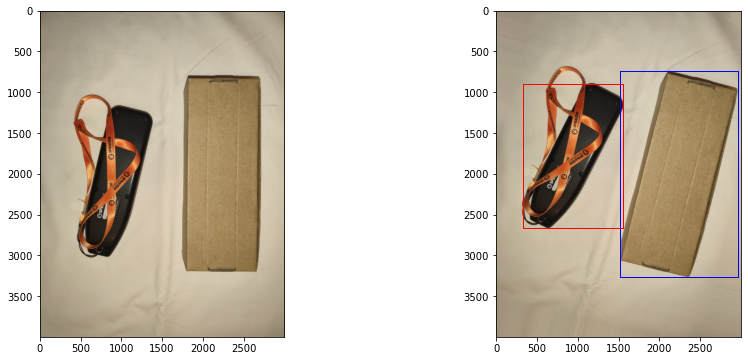

Test result:True
05.jpg


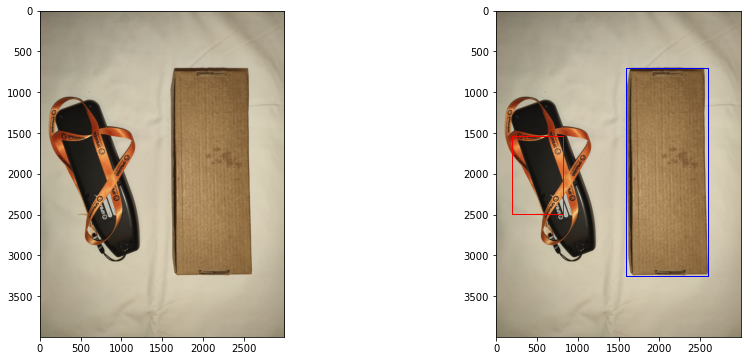

Test result:True
06.jpg


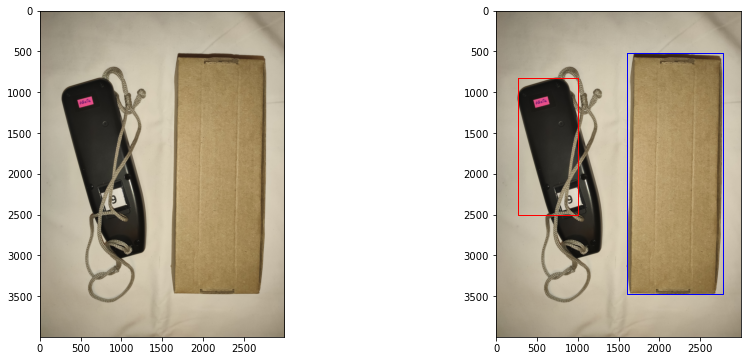

Test result:True
07.jpg


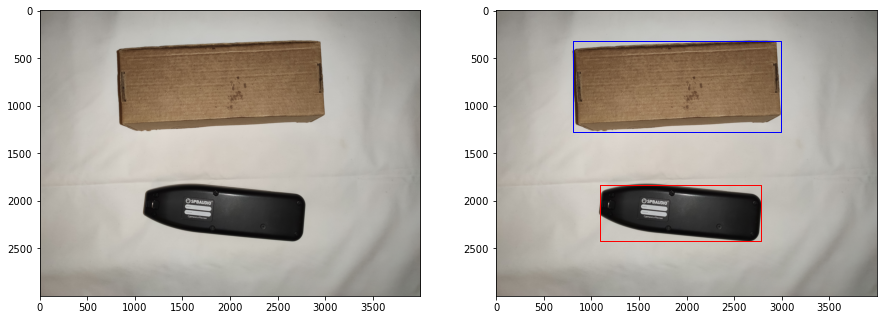

Test result:True
08.jpg


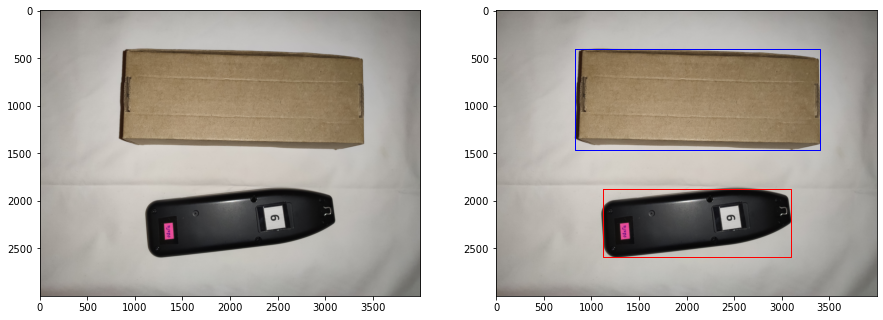

Test result:True
09.jpg
1.4479407481628934
1.4654915451103223


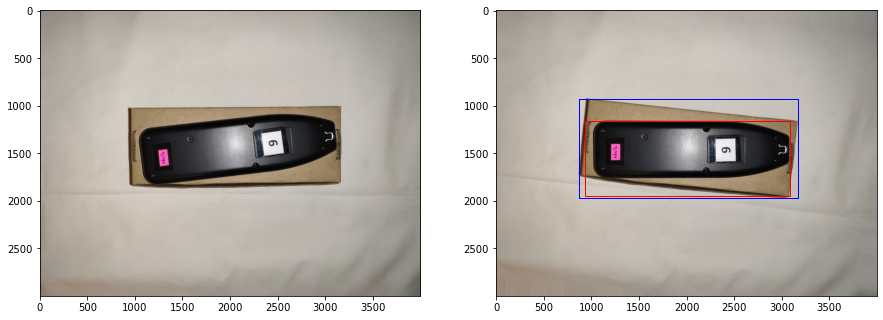

Test result:True
10.jpg


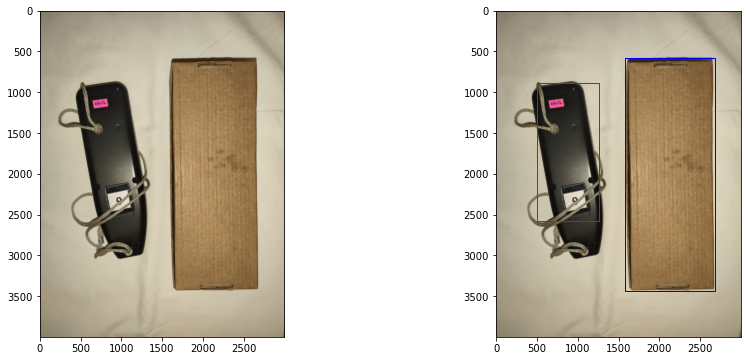

Test result:True
11.jpg


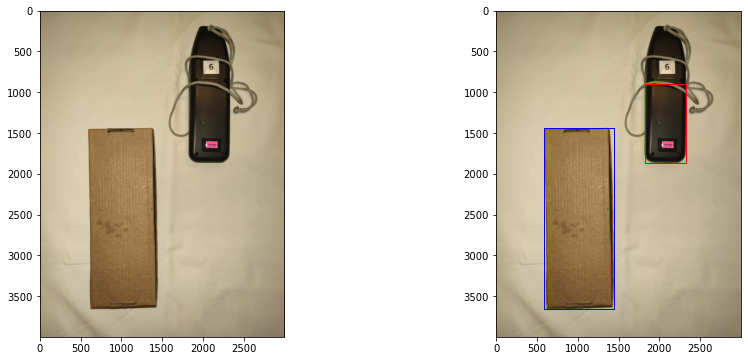

Test result:True
12.jpg


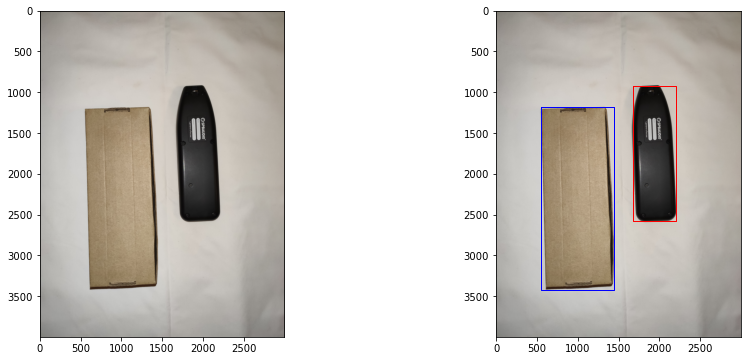

Test result:True
13.jpg


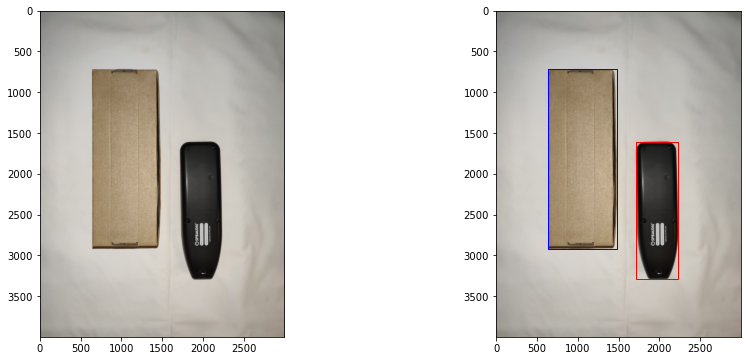

Test result:True
14.jpg


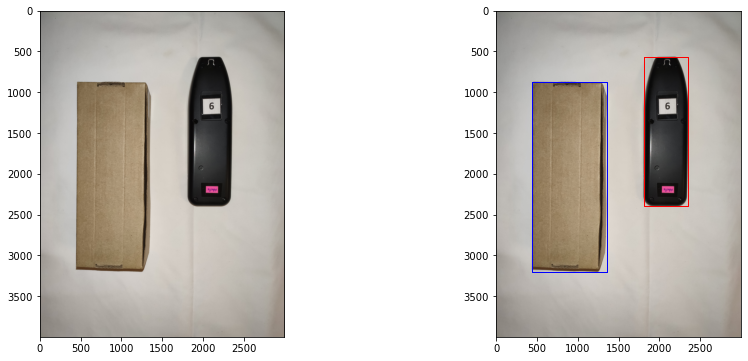

Test result:True
15.jpg


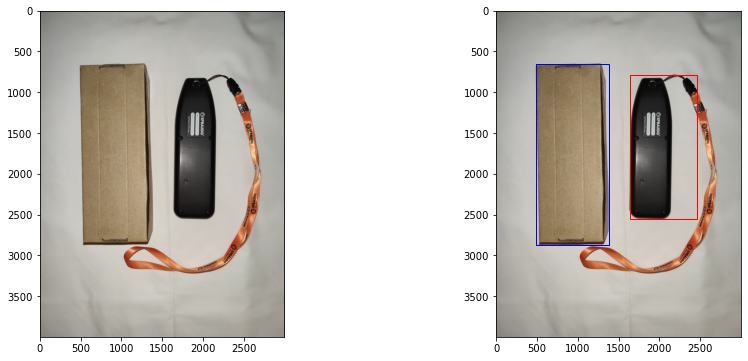

Test result:True
16.jpg


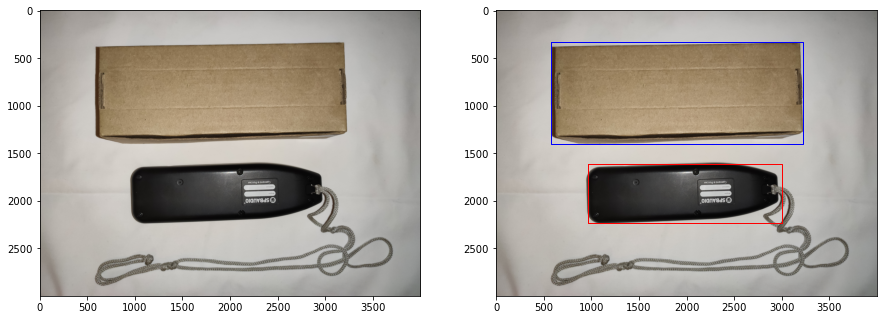

Test result:True
17.jpg


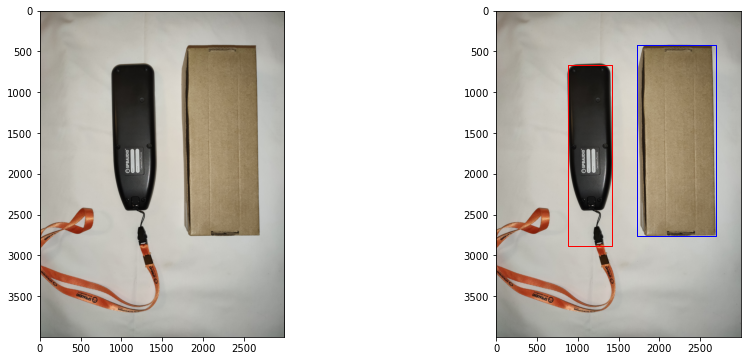

Test result:True
18.jpg


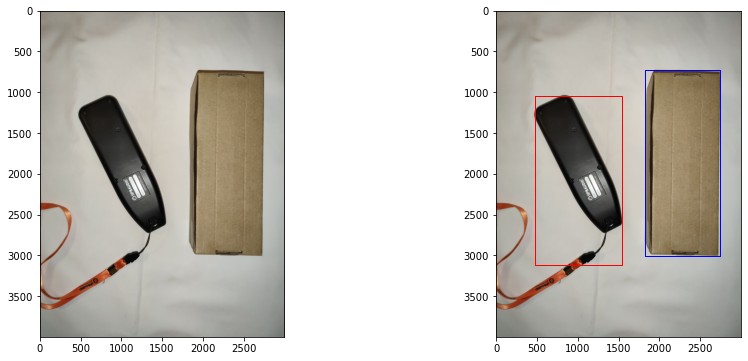

Test result:False
19.jpg


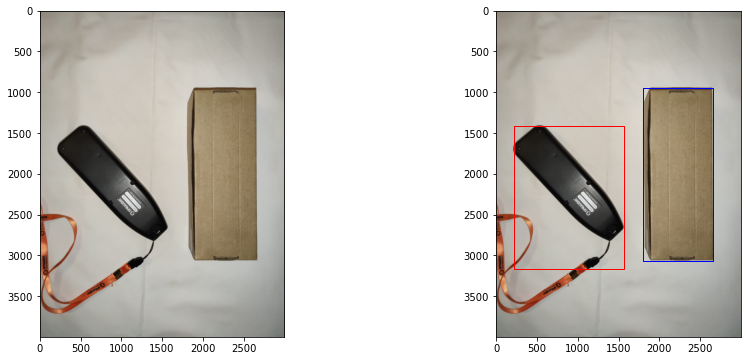

Test result:False
20.jpg


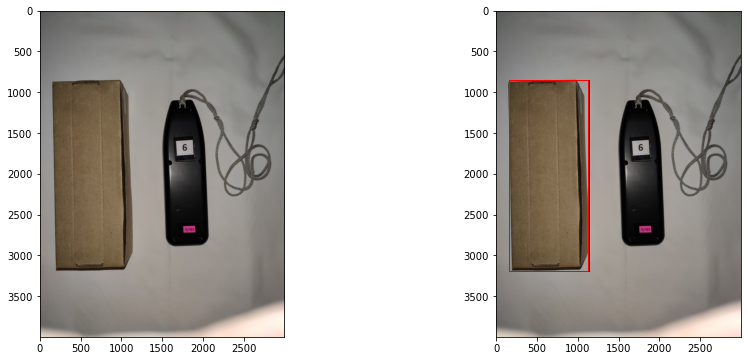

Test result:True
21.jpg


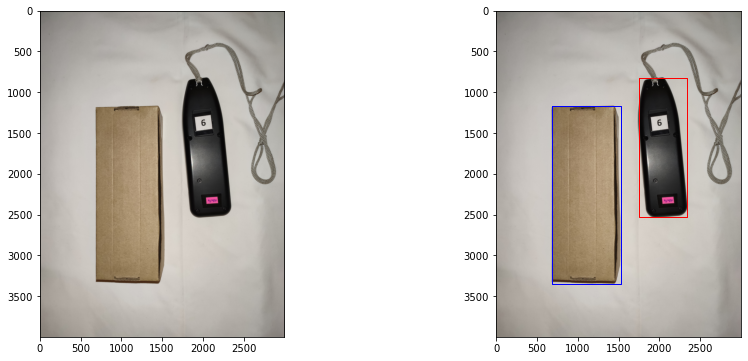

Test result:True
22.jpg
1.4479407481628934


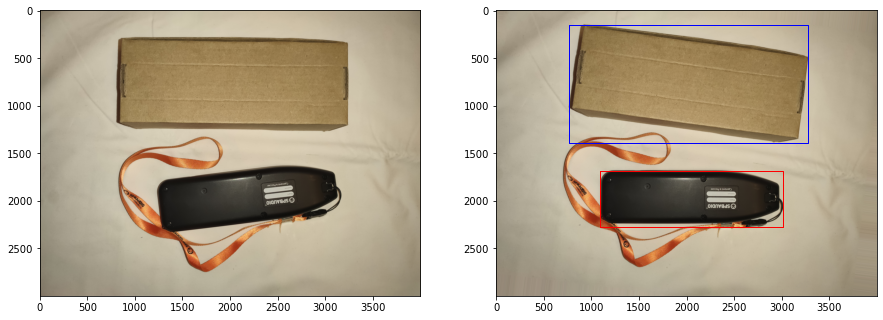

Test result:True
23.jpg


In [29]:
def run(folder, real_answer=True):
    good_answer = 0
    for name in os.listdir(folder):
        path = os.path.join(folder, name)
        img = imread(path)
        res = eval_tests(img)
        if res == real_answer:
            good_answer += 1
        print(name)
    return good_answer, len(os.listdir(folder))

true_neg, neg_data_len = run("dataSet/False/", False)
true_pos, pos_data_len = run("dataSet/True/", True)

In [30]:
print(f'Right negatives: {true_neg} / {neg_data_len}' )
print(f'Right positives: {true_pos} / {pos_data_len}')

Right negatives: 20 / 26
Right positives: 21 / 23


1.2548819817411743
1.2548819817411743
1.237331184793745
1.2724327786886032


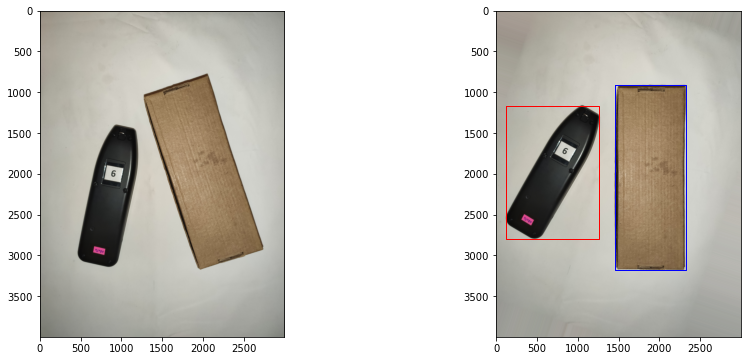

Test result:False


In [26]:
example_img = imread("dataSet/False/01.jpg")
res = eval_tests(example_img)

In [ ]:
img_gray = rgb2gray(example_img)
mask_ex = get_box_mask(img_gray)

In [ ]:
plt.imshow(mask_ex)
plt.show()

In [ ]:
total_mask = get_total_mask(img_gray)
audio_mask = binary_dilation(get_audio_mask(img_gray), selem=np.ones((10, 10)))
box_mask = binary_opening(total_mask ^ audio_mask, selem=np.ones((20, 20)))
plt.imshow(box_mask)
plt.show()
find_box_center(box_mask)

In [ ]:
plt.imshow(img_gray)
plt.show()